In [21]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller,acf, pacf
from  statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
#import plotly as pt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_predict,plot_acf,plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [6]:
beer=pd.read_csv('Time Series\monthly-beer-production-in-austr.csv')
beer['Month']=pd.to_datetime(beer.Month)
beer

,Month,Monthly beer production
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9
...,...,...
471,1995-04-01,127.0
472,1995-05-01,151.0
473,1995-06-01,130.0
474,1995-07-01,119.0


Text(0, 0.5, 'Beer Production')

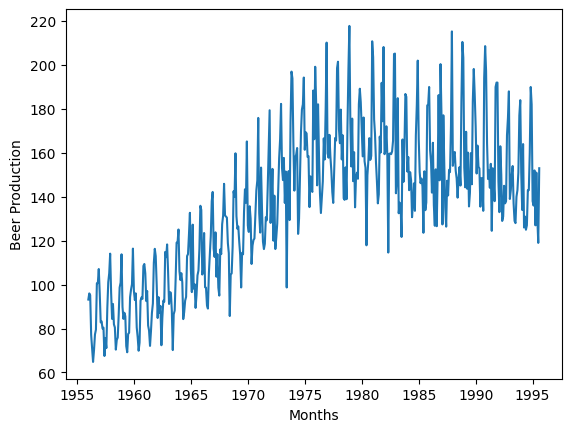

In [7]:
plt.plot(beer['Month'],beer['Monthly beer production'])
plt.xlabel('Months')
plt.ylabel('Beer Production')

In [8]:
df=beer.copy()
df['Year']=pd.DatetimeIndex(df['Month']).year
df['MonthNum']=pd.DatetimeIndex(df['Month']).month
pd.set_option('display.max_rows',50) #None
df=df.drop('Month',axis=1)
df

,Monthly beer production,Year,MonthNum
0,93.2,1956,1
1,96.0,1956,2
2,95.2,1956,3
3,77.1,1956,4
4,70.9,1956,5
...,...,...,...
471,127.0,1995,4
472,151.0,1995,5
473,130.0,1995,6
474,119.0,1995,7


<Axes: xlabel='MonthNum', ylabel='Monthly beer production'>

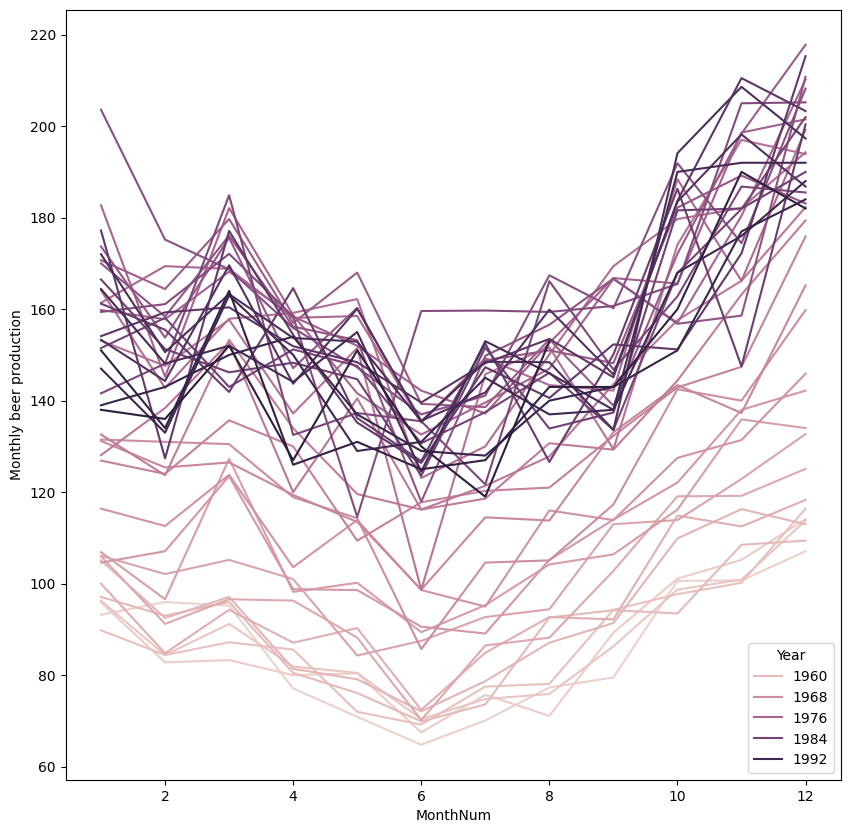

In [55]:
plt.figure(figsize=(10,10))
sns.lineplot(x='MonthNum',y='Monthly beer production',hue='Year',data=df)

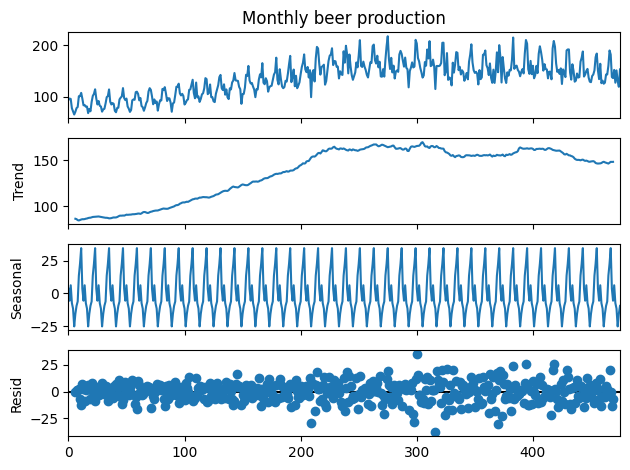

In [10]:
decomposition = sm.tsa.seasonal_decompose(df['Monthly beer production'], model='additive',period=12) 
fig = decomposition.plot()

In [11]:
def stationarity_test(x):
    x.rolling_mean = x.rolling(window = 12).mean()
    x.rolling_std = x.rolling(window = 12).std()
    
    sns.lineplot(x)
    sns.lineplot(x.rolling_mean,color='red')
    sns.lineplot(x.rolling_std,color='blue')
    
    print('ADF Test analysis below')
    adf=adfuller(x)
    df_output = pd.Series(adf[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in adf[4].items():
        df_output['Critical Value (%s)' %key]=value
    print(df_output)

ADF Test analysis below
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


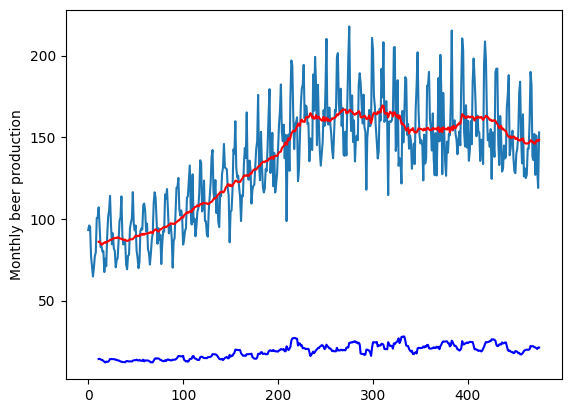

In [12]:
stationarity_test(df['Monthly beer production'])

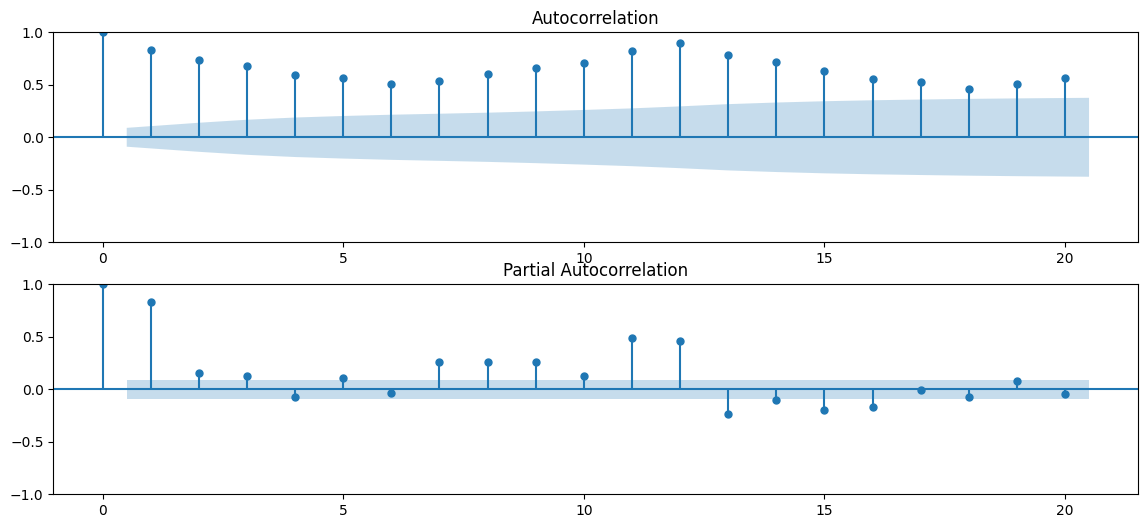

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df['Monthly beer production'], lags=20, ax=ax1)
ax2 = plot_pacf(df['Monthly beer production'], lags=20, ax=ax2)
plt.show()

###1st Order Differencing

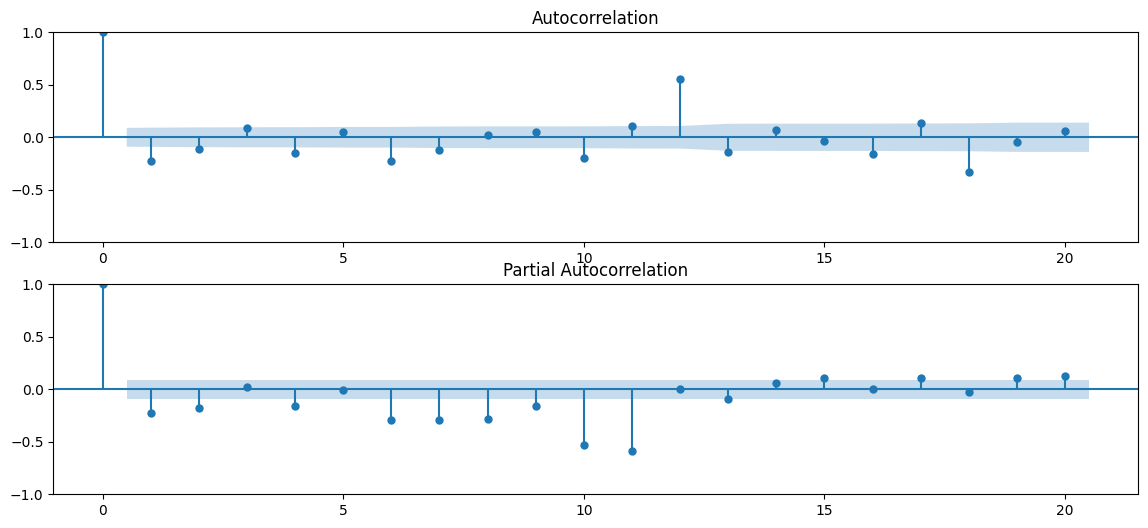

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df['Monthly beer production'].diff().dropna(), lags=20, ax=ax1)
ax2 = plot_pacf(df['Monthly beer production'].diff().dropna(), lags=20, ax=ax2)
plt.show()

In [19]:
diff=df['Monthly beer production'].diff().dropna()
diff

1       2.8
2      -0.8
3     -18.1
4      -6.2
5      -6.1
       ... 
471   -25.0
472    24.0
473   -21.0
474   -11.0
475    34.0
Name: Monthly beer production, Length: 475, dtype: float64

In [15]:
from pmdarima import auto_arima

In [23]:
stepwise_fit= model = auto_arima(df['Monthly beer production'],
                      d=1, D=1, m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=4, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4012.558, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3818.509, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3484.024, Time=2.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3648.020, Time=0.43 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=3.63 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3590.977, Time=1.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=4.99 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3474.251, Time=1.95 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3640.959, Time=0.65 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3468.503, Time=4.17 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3581.675, Time=1.97 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=3

In [24]:
stepwise_fit= model = auto_arima(diff,
                      d=1, D=1, m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=4, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4511.764, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4227.893, Time=1.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4280.366, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4208.693, Time=2.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.53 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4435.411, Time=1.07 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3919.772, Time=2.88 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3967.466, Time=0.98 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=3836.717, Time=4.27 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=3837.307, Time=2.25 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=3836.104, Time=7.01 sec
 ARIMA(2,1,0)(1,1,2)[12]             : 

In [45]:
train=df['Monthly beer production'].iloc[:350]
test=df['Monthly beer production'].tail(126)
test

350    146.2
351    148.3
352    144.7
353    123.6
354    151.6
       ...  
471    127.0
472    151.0
473    130.0
474    119.0
475    153.0
Name: Monthly beer production, Length: 126, dtype: float64

In [35]:
model=ARIMA(train,order=(5,1,1),seasonal_order=(0,1,2,12))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:               Monthly beer production   No. Observations:                  350
Model:             ARIMA(5, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1235.616
Date:                               Tue, 04 Mar 2025   AIC                           2489.232
Time:                                       19:48:26   BIC                           2523.613
Sample:                                            0   HQIC                          2502.936
                                               - 350                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2233      0.078     -2.856      0.004      -0.377      -0.070
ar.L2         -0.2891      0.075     -3.843      0.000      -0.437      -0.142
ar.L3         -0.0780      0.084     -0.926      0.355      -0.243       0.087
ar.L4         -0.1991      0.065     -3.081      0.002      -0.326      -0.072
ar.L5         -0.0014      0.054     -0.026      0.979      -0.107       0.104
ma.L1         -0.7891      0.060    -13.134      0.000      -0.907      -0.671
ma.S.L12      -0.7595      0.049    -15.657      0.000      -0.855      -0.664
ma.S.L24      -0.0698      0.047     -1.487      0.137      -0.162       0.022
sigma2        85.5696      4.779     17.904      0.000      76.202      94.937
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               126.53
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.84   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predict=model.forecast(steps=len(test))
new=pd.concat([test,predict],axis=1)
pd.set_option('display.max_rows',None)
new

,Monthly beer production,predicted_mean
350,146.2,159.672078
351,148.3,146.754193
352,144.7,142.053941
353,123.6,132.530931
354,151.6,137.861126
355,133.9,150.047105
356,137.4,146.688629
357,181.6,166.711967
358,182.0,180.347981
359,190.0,196.670056


<Axes: >

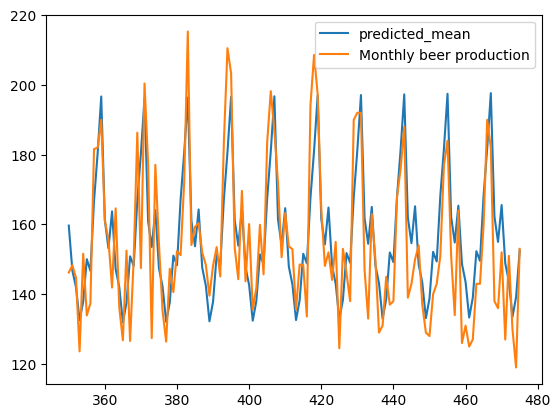

In [58]:
predict.plot(legend=True)
test.plot(legend=True)

In [109]:
from pandas.tseries.offsets import DateOffset
future_dates=pd.date_range("1995-09-01","1997-12-01",freq='MS')
future_dates=pd.DataFrame(future_dates)
future_dates

,0
0,1995-09-01
1,1995-10-01
2,1995-11-01
3,1995-12-01
4,1996-01-01
5,1996-02-01
6,1996-03-01
7,1996-04-01
8,1996-05-01
9,1996-06-01


In [112]:
future=model.predict(start=480,end=507)
future=future.reset_index()

In [113]:
df_forecast1=pd.concat([future_dates,future],axis=1)
forecast_df=df_forecast1.rename(columns={0:'Months','index':'A'})
forecast_df.drop('A',axis=1)

,Months,predicted_mean
0,1995-09-01,162.488692
1,1995-10-01,155.176290
2,1995-11-01,165.744786
3,1995-12-01,149.037541
4,1996-01-01,143.875501
5,1996-02-01,133.681633
6,1996-03-01,139.311005
7,1996-04-01,152.686598
8,1996-05-01,149.922970
9,1996-06-01,168.715316


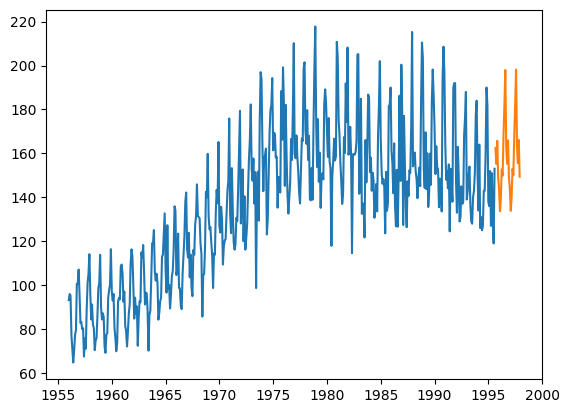

In [114]:
plt.plot(beer['Month'],beer['Monthly beer production'])
plt.plot(forecast_df['Months'],forecast_df['predicted_mean'])
